Monte Carlo Prediction in BlackJack

In [ ]:
!pip install gym matplotlib numpy
!wget https://raw.githubusercontent.com/udacity/deep-reinforcement-learning/master/monte-carlo/plot_utils.py

--2025-03-28 06:36:11--  https://raw.githubusercontent.com/udacity/deep-reinforcement-learning/master/monte-carlo/plot_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2346 (2.3K) [text/plain]
Saving to: ‘plot_utils.py’

plot_utils.py       100%[===================>]   2.29K  --.-KB/s    in 0s      

2025-03-28 06:36:11 (30.7 MB/s) - ‘plot_utils.py’ saved [2346/2346]



In [ ]:
import os
print(os.listdir())  # Should list plot_utils.py
import sys
import gym
import numpy as np
from collections import defaultdict

from plot_utils import plot_blackjack_values, plot_policy
env = gym.make('Blackjack-v1')
print(env.observation_space)
print(env.action_space)

['.config', 'plot_utils.py', 'sample_data']
Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
!pip install --upgrade numpy gymnasium

In [ ]:
for i_episode in range(3):
    state = env.reset()
    while True:
        print(state)
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        if done:
            print('End game! Reward: ', reward)
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state = bj_env.reset()
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

(17, 2, False)
End game! Reward:  -1.0
You lost :(

(10, 10, False)
(21, 10, True)
End game! Reward:  1.0
You won :)

(17, 1, False)
End game! Reward:  -1.0
You lost :(



In [ ]:
for i in range(3):
    print(generate_episode_from_limit_stochastic(env))
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    for i_episode in range(1, num_episodes + 1):
        if i_episode % 1000 == 0:
            print(f"\rEpisode {i_episode}/{num_episodes}.", end="")
            sys.stdout.flush()

        episode = generate_episode(env)
        states, actions, rewards = zip(*episode)

        G = 0
        for t in reversed(range(len(episode))):
            G = gamma * G + rewards[t]
            if (states[t], actions[t]) not in list(zip(states[:t], actions[:t])):  # First-visit check
                returns_sum[states[t]][actions[t]] += G
                N[states[t]][actions[t]] += 1
                Q[states[t]][actions[t]] = returns_sum[states[t]][actions[t]] / N[states[t]][actions[t]]

    return Q

[((10, 5, False), np.int64(0), 1.0)]
[((14, 2, False), np.int64(1), 0.0), ((17, 2, False), np.int64(0), 1.0)]
[((13, 10, False), np.int64(1), 0.0), ((20, 10, False), np.int64(0), 1.0)]


In [ ]:
import numpy as np
import sys
from collections import defaultdict

In [ ]:
def mc_control(env, num_episodes, alpha=0.1, gamma=1.0, epsilon=0.1):

    # Number of actions available in the environment
    nA = env.action_space.n

    # Initialize the Q-table as a dictionary mapping states to action-value estimates
    Q = defaultdict(lambda: np.zeros(nA))

    def epsilon_greedy_policy(state):
        """
        Returns an epsilon-greedy probability distribution over actions for a given state.

        With probability (1 - epsilon), chooses the action with the highest Q-value.
        With probability epsilon, chooses a random action to encourage exploration.
        """
        A = np.ones(nA) * (epsilon / nA)  # Initialize all actions with equal probability for exploration
        best_action = np.argmax(Q[state])  # Find the action with the highest Q-value
        A[best_action] += (1.0 - epsilon)  # Assign higher probability to the best action
        return A

    # Iterate over multiple episodes to improve Q-values and derive an optimal policy
    for i_episode in range(1, num_episodes + 1):
        # Print progress every 1000 episodes
        if i_episode % 1000 == 0:
            print(f"\rEpisode {i_episode}/{num_episodes}.", end="")
            sys.stdout.flush()

        # Generate an episode using the current policy
        episode = []
        state = env.reset()  # Reset the environment to get the initial state
        done = False  # Track whether the episode has ended

        while not done:
            # Select an action using the epsilon-greedy policy
            action_probs = epsilon_greedy_policy(state)
            action = np.random.choice(np.arange(nA), p=action_probs)  # Sample action based on probability distribution

            # Take action in the environment and observe the next state and reward
            next_state, reward, done, _ = env.step(action)

            # Store (state, action, reward) tuple in the episode list
            episode.append((state, action, reward))

            # Move to the next state
            state = next_state

        # Process the collected episode using Monte Carlo policy evaluation
        states, actions, rewards = zip(*episode)  # Unzip episode into separate lists
        G = 0  # Initialize return (cumulative discounted reward)

        # Iterate over the episode in reverse order to compute returns and update Q-values
        for t in reversed(range(len(episode))):
            G = gamma * G + rewards[t]  # Compute the discounted return

            # Every-visit MC: update Q-value for every occurrence of (state, action)
            Q[states[t]][actions[t]] += alpha * (G - Q[states[t]][actions[t]])

    # Extract the optimal policy from the learned Q-table
    policy = {state: np.argmax(Q[state]) for state in Q}

    return policy, Q

Episode 500000/500000.

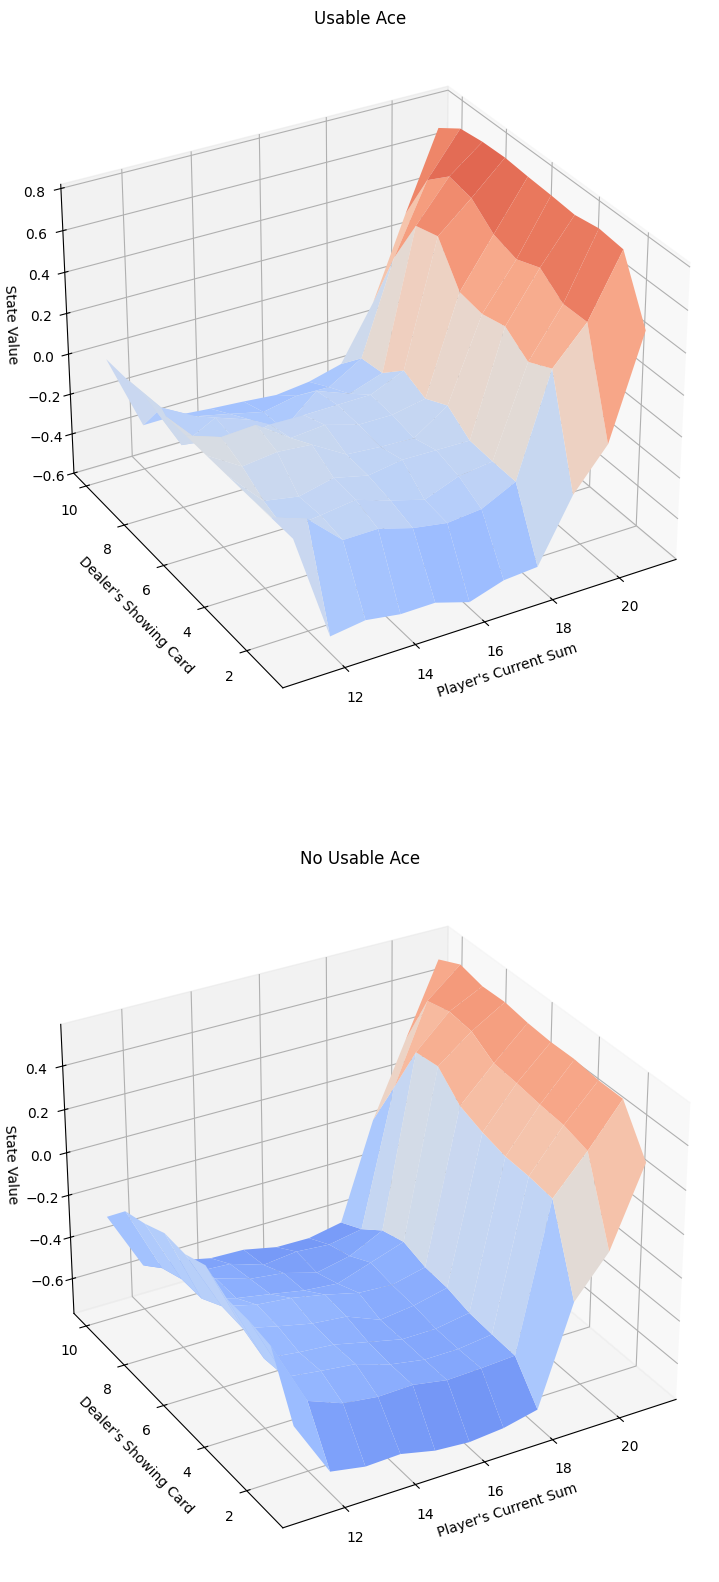

Episode 500000/500000.

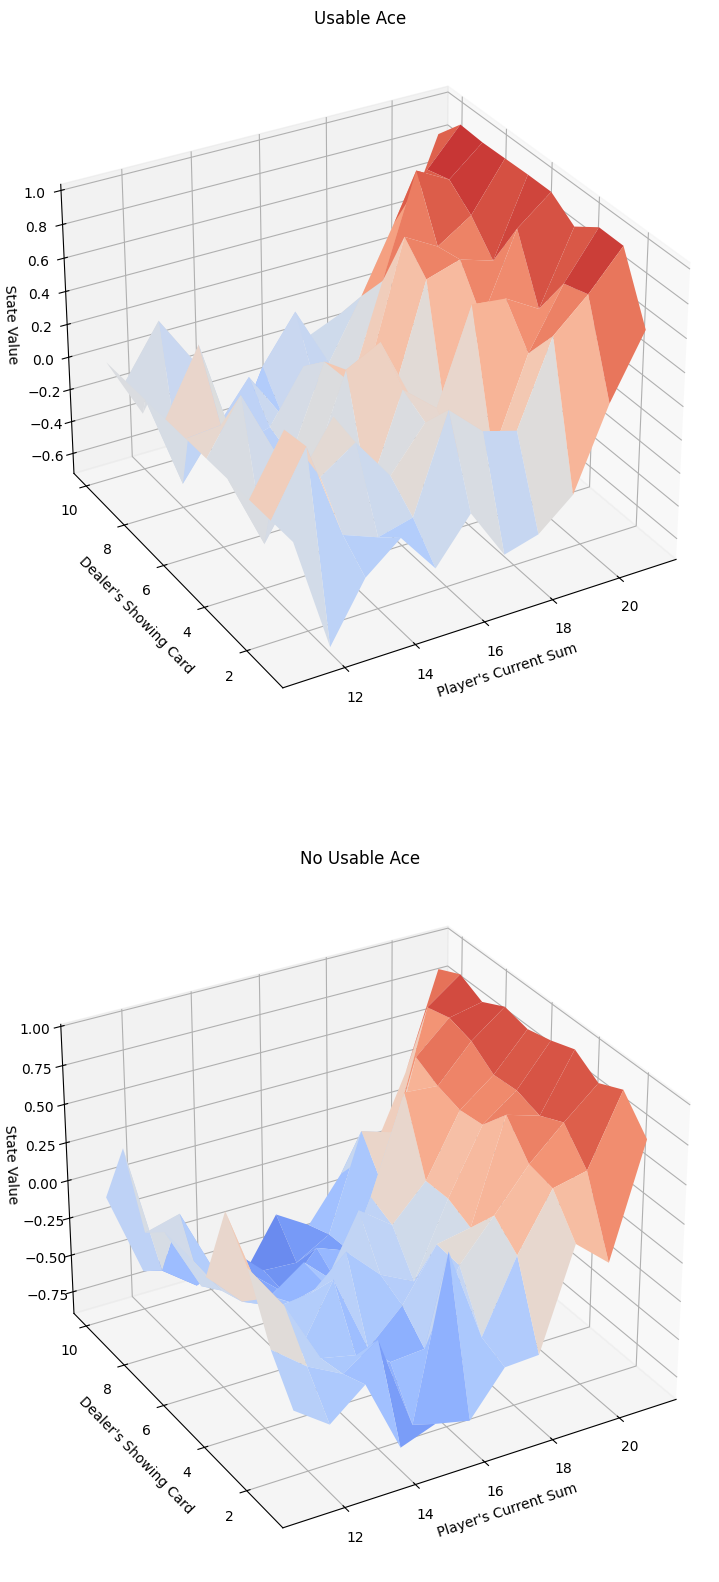

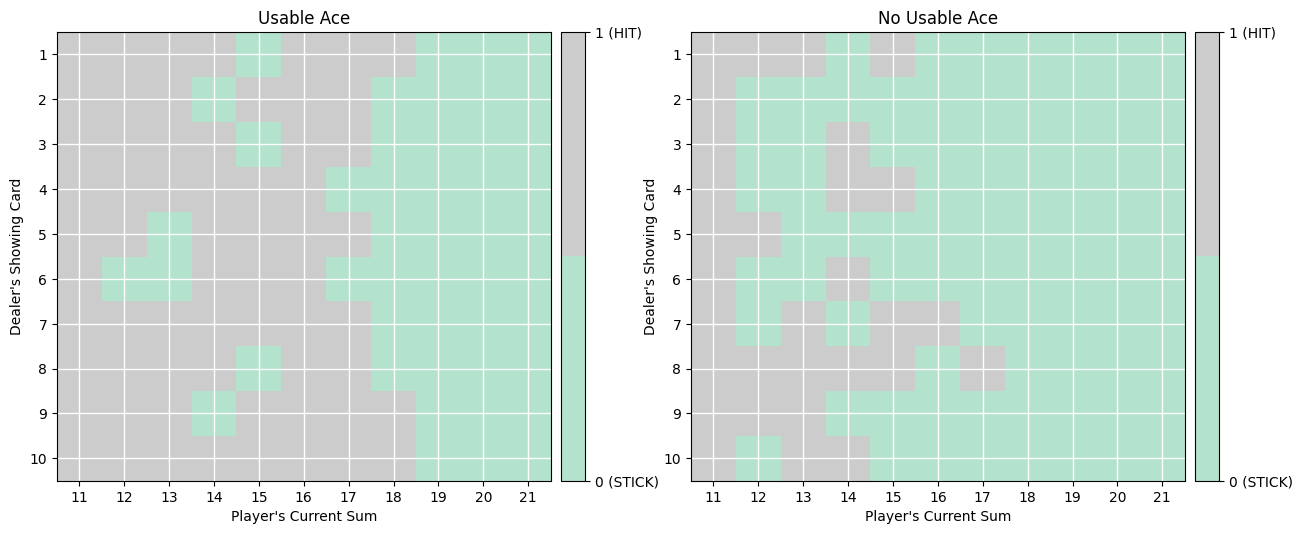

State: (13, 10, False), Q-values: [-0.75469618 -0.5472837 ]
State: (19, 1, False), Q-values: [ 0.22072578 -0.84323669]
State: (16, 10, False), Q-values: [-0.51248014 -0.76451248]
State: (16, 1, False), Q-values: [-0.71868713 -0.82644356]
State: (19, 8, False), Q-values: [ 0.59382576 -0.5416886 ]
State: (14, 6, False), Q-values: [-0.67501745 -0.46889355]
State: (17, 1, False), Q-values: [-0.43950605 -0.44919496]
State: (19, 6, False), Q-values: [ 0.47739667 -0.93625162]
State: (5, 1, False), Q-values: [-0.87089668 -0.45990417]
State: (14, 10, False), Q-values: [-0.93254741 -0.73772711]
State: (21, 10, False), Q-values: [ 0.83928964 -1.        ]
State: (12, 8, False), Q-values: [-0.93678276 -0.00342207]
State: (17, 2, False), Q-values: [-0.3772277  -0.72775825]
State: (17, 10, False), Q-values: [-0.64993615 -0.92687054]
State: (17, 7, False), Q-values: [-0.08749353 -0.48159295]
State: (15, 10, True), Q-values: [-0.82356825 -0.69089229]
State: (13, 1, False), Q-values: [-0.76404979 -0.268

In [ ]:
# obtain the action-value function
Q = mc_prediction_q(env, 500000, generate_episode_from_limit_stochastic)

# obtain the corresponding state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)
# obtain the estimated optimal policy and action-value function
policy, Q = mc_control(env, num_episodes=500000, epsilon=0.1)
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)
# plot the policy
plot_policy(policy)
for state, actions in Q.items():
    print(f"State: {state}, Q-values: {actions}")